In [25]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = True
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from matplotlib import pyplot as plt
import numpy as np
from util import util
import igraph as ig
    
#from util import cst
#import numpy as np
#from matplotlib import pyplot as plt
#import pandas as pd
#from tensorflow import keras
#from tensorflow.keras import layers, callbacks
#from tensorflow_probability import distributions
#from sklearn.metrics import r2_score, mean_squared_error
#from tensorflow.keras import backend as k

# Load data
#data_folder = '/app/data'
#data = cst.load_cmapss_data(data_folder)

# Identify input columns
#dt_in = list(data.columns[3:-1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plan

## Plan

* Mining navigation paths
  - Count visited pages
  - Count visited links
* V1:
  - Loops allowed
  - Pricing via poly-time algo
* V2:
  - No loops
  - Pricing via CP-SAT?
* Master
  - Reconstruct available counts
  - V1: unconstrained
  - V2: minimum cover for all nodes

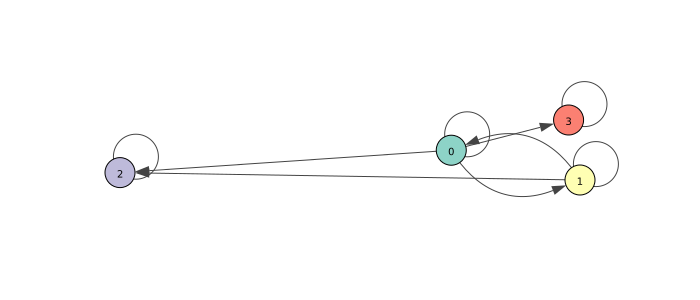

In [26]:
from util import util
import igraph as ig
g = util.build_website_graph(nnodes=4, rate=3, extra_arc_fraction=0.25, seed=42)
root = g.vs[0]

#util.display_graph(g)
ig.plot(g, **util.get_visual_style(g), bbox=(700, 300), margin=120)

In [27]:
util.route_random_flow(root, min_units=1, max_units=10, eoh=10, max_len=7)

(7.497988950401423, [(4, 0), (5, 1)])

In [28]:
eoh = 4
flows, paths = util.build_random_paths(g, min_paths=3, max_paths=5,
                                                           min_units=1, max_units=10, eoh=eoh,
                                                           seed=10)
util.print_ground_truth(flows, paths, sort='descending')

9.58: 3,0
5.45: 0,1 > 1,1 > 2,0 > 3,1
2.52: 1,0 > 2,0 > 3,2
1.23: 0,1 > 1,2 > 2,2 > 3,2


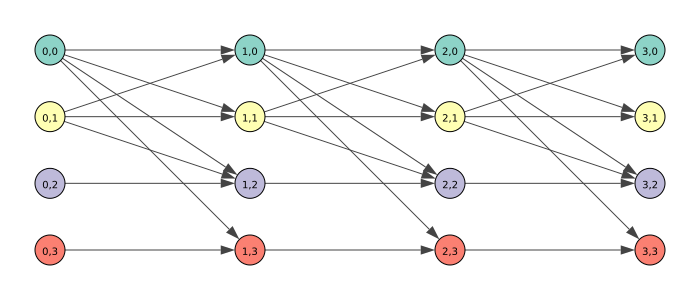

In [29]:
tug = util.build_time_unfolded_graph(g, eoh=eoh)
ig.plot(tug, **util.get_visual_style(tug), bbox=(700, 300), margin=50)

In [30]:
node_counts, arc_counts = util.get_counts(tug, flows, paths)
node_counts

{(0, 0): 0,
 (0, 1): 6.677854921559987,
 (0, 2): 0,
 (0, 3): 0,
 (1, 0): 2.521997529062819,
 (1, 1): 5.451309365800277,
 (1, 2): 1.2265455557597105,
 (1, 3): 0,
 (2, 0): 7.9733068948630965,
 (2, 1): 0,
 (2, 2): 1.2265455557597105,
 (2, 3): 0,
 (3, 0): 9.58054011575443,
 (3, 1): 5.451309365800277,
 (3, 2): 3.7485430848225296,
 (3, 3): 0}

In [31]:
tugc = util.apply_weights(tug, node_counts, arc_counts)
ig.plot(tugc, **util.get_visual_style(tugc), bbox=(700, 300), margin=50)

AttributeError: module 'util.util' has no attribute 'apply_weights'

In [ ]:
tugcs, tugcs_source = util._add_source_to_tug(tugc)
ig.plot(tugcs, **util.get_visual_style(tugcs), bbox=(700, 300), margin=50)

In [ ]:
tug_paths = util.enumerate_paths(tugcs, tugcs_source, exclude_source=True)

for i, p in enumerate(tug_paths):
    print(f'{i}: {p}')

In [ ]:
tmp = util.tug_paths_to_original(tugcs, tug_paths)
for i, p in enumerate(tmp):
    print(f'{i}: {p}')

In [ ]:
paths

In [ ]:
#pidx = [0, 26, 32, 30, 16]
#tug_paths = [tug_paths[i] for i in pidx]
#tug_paths

$$
\arg \min_{x} \left\{\|Vx - \hat{v}\|_2^2 + \|Ex - \hat{e}\|_2^2 \mid x \geq 0 \right\}
$$

$$\begin{align}
\|Ax - b\|_2^2 &= (Ax - b)^T (Ax - b) \\
&= x^T A^TA x - x^T A^T b - b^T Ax + b^T b \\
&\propto \frac{1}{2} x^T (A^TA) x - \frac{1}{2} x^T A^T b - \frac{1}{2} b^T Ax \\
&= \frac{1}{2} x^T (A^TA) x + (-A^Tb)^Tx
\end{align}$$

Since $y^Tx = x^Ty$ if the result is a scalar

$$
\|Vx - \hat{v}\|_2^2 + \|Ex - \hat{e}\|_2^2 \\
\propto \frac{1}{2} \|Vx - \hat{v}\|_2^2 + \frac{1}{2} \|Ex - \hat{e}\|_2^2 \\
= \frac{1}{2}x^T (V^T V) x + (-V^T \hat{v})^T x + \frac{1}{2} x^T (E^T E) x + (-E^T \hat{e})^T x \\
= \frac{1}{2} x^T P x + q^T x
$$
where:
$$
P = V^T V + E^T E \\
q = -V^T \hat{v} -E^T \hat{e}
$$
and $P$ is guaranteed to be positive semi-definite

In [ ]:
V, E = util._paths_to_coefficient_matrices(tug, tug_paths)
v, e = util._counts_to_target_vectors(tug, node_counts, arc_counts)

In [ ]:
node_counts

In [ ]:
v.reshape((-1,1))

In [ ]:
arc_counts

In [ ]:
e.reshape((-1,1))

In [ ]:
plt.close('all')
util.plot_matrix(V.toarray(), v, figsize=figsize, title='V', title_b='v')

In [ ]:
plt.close('all')
util.plot_matrix(E.toarray(), e, figsize=figsize, title='E', title_b='e')

In [ ]:
#prb = util.PathSelectionSolver(tug, node_counts, arc_counts)
#sol = prb.solve(tug_paths)
#reconstructed_paths = prb.sol_to_paths()
#reconstructed_paths

rflows, rpaths = util.solve_path_selection_full(tug, node_counts, arc_counts, verbose=1)
print('FLOW: PATH')
util.print_solution(tug, rflows, rpaths, sort='descending')
sse = util.get_reconstruction_error(tug, rflows, rpaths, node_counts, arc_counts)
print(f'SSE: {sse:.2f}')

In [ ]:
util.print_ground_truth(flows, paths, sort='descending')

In [ ]:
sse = util.get_reconstruction_error(tug, rflows, rpaths, node_counts, arc_counts)
sse

In [ ]:
rec_node_counts, rec_arc_counts = util.get_counts(tug, rflows, rpaths)
util.plot_dict(rec_node_counts, figsize=figsize, label='reconstructed', data2=node_counts, label2='target',
              title='Node Counts')

In [ ]:
cflows, cpaths, _ = util.consolidate_paths(tug, rpaths, node_counts, arc_counts)
util.print_solution(tug, cflows, cpaths, sort='descending')

In [ ]:
util.print_ground_truth(flows, paths, sort='descending')

In [ ]:
node_res, arc_res = util._get_residuals(tug, cflows, cpaths, node_counts, arc_counts)
node_res

In [ ]:
# Obtain dual multipliers assuming a standard form
#master.get_standard_duals()

$$
\mathcal{L}(x, \lambda) = \frac{1}{2} x^T P x + q^T x + \lambda^T (-x) \\
\nabla_x \mathcal{L}(x, \lambda) = \frac{1}{2} x^T(P + P^T) + q - \lambda^T
$$

$$
\frac{1}{2} \|Vx - \hat{v}\|_2^2 = \frac{1}{2} \sum_{i = 1}^m \left(\sum_{j=1}^n V_{ij} x_{j} - \hat{v}_i\right)^2
$$
$$
\frac{\partial}{\partial x_j} \frac{1}{2} \|Vx - \hat{v}\|_2^2 = \sum_{i=1}^m \left(\sum_{j=1}^n V_{ij} x_{j} - \hat{v}_i\right) V_{ij}
$$


In [ ]:
tug_path_selection_0 = tug_paths[1:3]

rflows0, rpaths0 = util.solve_path_selection_full(tug, node_counts, arc_counts,
                                             initial_paths=tug_path_selection_0, verbose=1)

#master = util.PathSelectionSolver(tug, node_counts, arc_counts)
#sol = master.solve(tug_path_selection_0)
#raw_paths_0 = master.sol_to_paths()
#raw_paths_0
util.print_solution(tug, rflows0, rpaths0, sort='descending')

In [ ]:
nres, ares = util._get_residuals(tug, rflows0, rpaths0, node_counts, arc_counts)
nres

In [ ]:
ares

In [ ]:
ncosts, npaths = util.solve_pricing_problem(tug, rflows0, rpaths0,
                                             node_counts, arc_counts, filter_paths=False)
print('COST: PATH')
util.print_solution(tug, ncosts, npaths, sort=None)

In [ ]:
neg_paths = [p for p, c in zip(npaths, ncosts) if c < 0]
tug_path_selection_1 = tug_path_selection_0 + neg_paths

rflows1, rpaths1 = util.solve_path_selection_full(tug, node_counts, arc_counts,
                                             initial_paths=tug_path_selection_1, verbose=1)

util.print_solution(tug, rflows1, rpaths1, sort='descending')


In [ ]:
neg_paths = [p for p, c in zip(npaths, ncosts) if c >= 0]
tug_path_selection_1 = tug_path_selection_0 + neg_paths

rflows1, rpaths1 = util.solve_path_selection_full(tug, node_counts, arc_counts,
                                             initial_paths=tug_path_selection_1, verbose=1)

util.print_solution(tug, rflows1, rpaths1, sort='descending')


In [ ]:
rflows_cg, rpaths_cg = util.trajectory_extraction_cg(tug, node_counts, arc_counts, max_iter=30, verbose=1)
print('FLOW: PATH')
util.print_solution(tug, rflows_cg, rpaths_cg, sort='descending')

In [ ]:
cflows_cg, cpaths_cg, copt = util.consolidate_paths(tug, rflows_cg, rpaths_cg, node_counts, arc_counts)
print('FLOW: PATH')
util.print_solution(tug, cflows_cg, cpaths_cg, sort='descending')

In [ ]:
print('FLOW: PATH')
util.print_ground_truth(flows, paths, sort='descending')

# Scalability

In [ ]:
nnodes2 = 8
eoh2 = 5
g2 = util.build_website_graph(nnodes=nnodes2, rate=3, extra_arc_fraction=0.25, seed=42)
flows2, paths2 = util.build_random_paths(g2, min_paths=nnodes2*eoh2/10, max_paths=3*nnodes2*eoh2/10,
                                       min_units=1, max_units=10, eoh=eoh2, seed=10)
tug2 = util.build_time_unfolded_graph(g2, eoh=eoh2)
node_counts2, arc_counts2 = util.get_counts(tug2, flows2, paths2)

#ig.plot(g2, **util.get_visual_style(g2), bbox=(700, 300), margin=120)

tugc2 = util.apply_weights(tug2, node_counts2, arc_counts2)
ig.plot(tugc2, **util.get_visual_style(tugc2), bbox=(700, 300), margin=50)

In [ ]:
%%time
rflows2, rpaths2 = util.solve_path_selection_full(tug2, node_counts2, arc_counts2, verbose=1)
print('FLOW: PATH')
util.print_solution(tug2, rflows2, rpaths2, sort='descending')
sse = util.get_reconstruction_error(tug2, rflows2, rpaths2, node_counts2, arc_counts2)
print(f'SSE: {sse:.2f}')

In [ ]:
%%time
rflows_cg2, rpaths_cg2 = util.trajectory_extraction_cg(tug2, node_counts2, arc_counts2,
                                                       max_iter=30, verbose=1, max_paths_per_iter=10)
print('FLOW: PATH')
util.print_solution(tug2, rflows_cg2, rpaths_cg2, sort='descending')
sse = util.get_reconstruction_error(tug2, rflows_cg2, rpaths_cg2, node_counts2, arc_counts2)
print(f'SSE: {sse:.2f}')

# Scale up even more

In [ ]:
nnodes3 = 20
eoh3 = 7
g3 = util.build_website_graph(nnodes=nnodes3, rate=3, extra_arc_fraction=0.25, seed=42)
flows3, paths3 = util.build_random_paths(g3, min_paths=nnodes3*eoh3/10, max_paths=3*nnodes3*eoh3/10,
                                       min_units=1, max_units=10, eoh=eoh3, seed=10)
tug3 = util.build_time_unfolded_graph(g3, eoh=eoh3)
node_counts3, arc_counts3 = util.get_counts(tug3, flows3, paths3)

In [ ]:
%%time
rflows_cg3, rpaths_cg3 = util.trajectory_extraction_cg(tug3, node_counts3, arc_counts3,
                                                       max_iter=30, verbose=1, max_paths_per_iter=10)
print('FLOW: PATH')
util.print_solution(tug3, rflows_cg3, rpaths_cg3, sort='descending')
sse = util.get_reconstruction_error(tug3, rflows_cg3, rpaths_cg3, node_counts3, arc_counts3)
print(f'SSE: {sse:.2f}')

# Noise and Minimum cover constraint

In [ ]:
nnodes4 = 4
eoh4 = 4
g4 = util.build_website_graph(nnodes=nnodes4, rate=3, extra_arc_fraction=0.25, seed=42)
flows4, paths4 = util.build_random_paths(g4, min_paths=nnodes4*eoh4/10, max_paths=5*nnodes4*eoh4/10,
                                       min_units=1, max_units=10, eoh=eoh4, seed=10)
tug4 = util.build_time_unfolded_graph(g4, eoh=eoh4)
node_counts4, arc_counts4 = util.get_counts(tug4, flows4, paths4)
node_counts4, arc_counts4 = util.add_proportional_noise(node_counts4, arc_counts4, sigma=0.3)

tugc4 = util.apply_weights(tug4, node_counts4, arc_counts4)
ig.plot(tugc4, **util.get_visual_style(tugc4), bbox=(700, 300), margin=50)

In [ ]:
tugs4, tugs_source4 = util._add_source_to_tug(tug4)
tug_paths4 = util.enumerate_paths(tugs4, tugs_source4, exclude_source=True)
A_mvc, l_mvc, u_mvc = util._min_vertex_cover_constraints(tug4, tug_paths4,
                                                         node_counts4, min_vertex_cover=0.8)
util.plot_matrix(A_mvc.toarray(), l_mvc, figsize=figsize, title='A_mvc', title_b='l_mvc')

In [ ]:
min_vertex_cover=0.8
alpha=10
rflows4, rpaths4, nneg_duals4, ncov_duals4 = util.solve_path_selection_full(tug4, node_counts4, arc_counts4,
                                                  min_vertex_cover=min_vertex_cover, alpha=alpha,
                                                  verbose=1, return_duals=True)
print('FLOW: PATH')
util.print_solution(tug4, rflows4, rpaths4, sort='descending')
sse = util.get_reconstruction_error(tug4, rflows4, rpaths4, node_counts4, arc_counts4)
print(f'SSE: {sse:.2f}')

In [ ]:
util.plot_dict({i:v for i, v in enumerate(nneg_duals4)}, figsize=figsize)

In [ ]:
util.plot_dict({i:v for i, v in enumerate(ncov_duals4)}, figsize=figsize)

In [24]:
ncosts4, npaths4 = util.solve_pricing_problem(tug4, rflows4, rpaths4,
                                             node_counts4, arc_counts4,
                                             cover_duals=ncov_duals4, alpha=alpha, filter_paths=True)
print('COST: PATH')
util.print_solution(tug4, ncosts4, npaths4, sort=None)

NameError: name 'tug4' is not defined

In [65]:
%%time
rflows_cg4, rpaths_cg4 = util.trajectory_extraction_cg(tug4, node_counts4, arc_counts4,
                                                       alpha=alpha, min_vertex_cover=min_vertex_cover,
                                                       max_iter=30, verbose=1, max_paths_per_iter=10)
print('FLOW: PATH')
util.print_solution(tug4, rflows_cg4, rpaths_cg4, sort='descending')
sse = util.get_reconstruction_error(tug4, rflows_cg4, rpaths_cg4, node_counts4, arc_counts4)
print(f'SSE: {sse:.2f}')

It.0, sse: 167.39, #paths: 26, new: 10
It.1, sse: 26.86, #paths: 35, new: 9
It.2, sse: 26.39, #paths: 41, new: 6
It.3, sse: 25.45, #paths: 43, new: 2
It.4, sse: 26.46, #paths: 43, new: 0
FLOW: PATH
4.98: 0,1 > 1,1 > 2,0 > 3,1
1.04: 0,1 > 1,2 > 2,2 > 3,2
0.38: 0,1 > 1,2 > 2,2
SSE: 26.46
CPU times: user 224 ms, sys: 896 µs, total: 225 ms
Wall time: 222 ms


# NP-hard Pricing Problem

In [62]:
ncosts4, npaths4 = util.solve_pricing_problem_maxwaits(tug4, rflows4, rpaths4,
                                             node_counts4, arc_counts4, max_waits=1,
                                             cover_duals=ncov_duals4,
                                             alpha=alpha,
                                             filter_paths=False,
                                             max_paths=None)
print('COST: PATH')
util.print_solution(tug4, ncosts4, npaths4, sort='ascending')

COST: PATH
1.51: 1,2
2.49: 1,0 > 2,1
2.49: 1,0 > 2,1 > 3,0
2.55: 1,0 > 2,1 > 3,2
3.12: 1,0 > 2,3
4.77: 0,1 > 1,0 > 2,1
4.77: 0,1 > 1,0 > 2,1 > 3,0
4.83: 0,1 > 1,0 > 2,1 > 3,2
5.04: 0,0 > 1,1 > 2,0 > 3,1
5.40: 0,1 > 1,0 > 2,3
5.42: 1,1 > 2,0 > 3,1
5.86: 2,0 > 3,1
6.00: 0,0 > 1,1 > 2,0 > 3,3
6.08: 0,0 > 1,1 > 2,0
6.13: 2,1
6.13: 2,1 > 3,0
6.14: 0,0 > 1,1 > 2,0 > 3,2
6.19: 2,1 > 3,2
6.35: 1,0
6.38: 1,1 > 2,0 > 3,3
6.40: 1,0 > 2,2
6.46: 1,1 > 2,0
6.50: 1,3
6.52: 1,1 > 2,0 > 3,2
6.77: 2,3
6.81: 2,0 > 3,3
6.90: 2,0
6.96: 2,0 > 3,2
8.33: 0,3
8.63: 0,1 > 1,0
8.63: 0,1 > 1,2
8.63: 0,1
8.68: 0,1 > 1,0 > 2,2
9.04: 0,0 > 1,3
9.04: 0,0 > 1,1
9.04: 0,0 > 1,2
9.04: 0,0
9.09: 0,0 > 1,1 > 2,2
9.42: 1,1
9.47: 1,1 > 2,2
9.92: 3,3
10.00: 0,2
10.00: 3,0
10.05: 2,2
10.06: 3,2
11.12: 3,1


In [76]:
%%time
rflows_cg4, rpaths_cg4 = util.trajectory_extraction_cg(tug4, node_counts4, arc_counts4,
                                                       alpha=alpha, min_vertex_cover=min_vertex_cover,
                                                       max_iter=30, verbose=1, max_paths_per_iter=10,
                                                       max_waits=None, force_lcg_pricing=True,
                                                       pricing_time_limit=10)
print('FLOW: PATH')
util.print_solution(tug4, rflows_cg4, rpaths_cg4, sort='descending')
sse = util.get_reconstruction_error(tug4, rflows_cg4, rpaths_cg4, node_counts4, arc_counts4)
print(f'SSE: {sse:.2f}')

It.0, sse: 167.39, #paths: 27, new: 11
It.1, sse: 110.18, #paths: 38, new: 11
It.2, sse: 22.77, #paths: 49, new: 11
It.3, sse: 26.92, #paths: 49, new: 0
FLOW: PATH
4.97: 0,1 > 1,1 > 2,0 > 3,1
1.40: 0,1 > 1,2 > 2,2 > 3,2
0.01: 0,0 > 1,2 > 2,2
SSE: 26.92
CPU times: user 238 ms, sys: 0 ns, total: 238 ms
Wall time: 235 ms
